## Load Data & Preprocessing

In [1]:
import pickle
import pandas as pd
import numpy as np

# Load files
with open('train_data.pkl', 'rb') as file:
  train_data = pickle.load(file)

with open('test_data.pkl', 'rb') as file:
  test_data = pickle.load(file)

# Removing unwanted columns:
columns_to_remove = ['Close', 'High', 'Low', 'Open', 'Next Return']

# Train data:
for key, df in train_data.items():
    train_data[key] = df.drop(columns=columns_to_remove, errors='ignore').dropna()

# Test data:
for key, df in test_data.items():
    test_data[key] = df.drop(columns=columns_to_remove, errors='ignore').dropna()

# Chosing Asset from [ABEV3, B3SA3, ELET3, VALE3, PETR4, ITUB4, IBOV]
asset = 'ABEV3'

## Correlation Heatmap

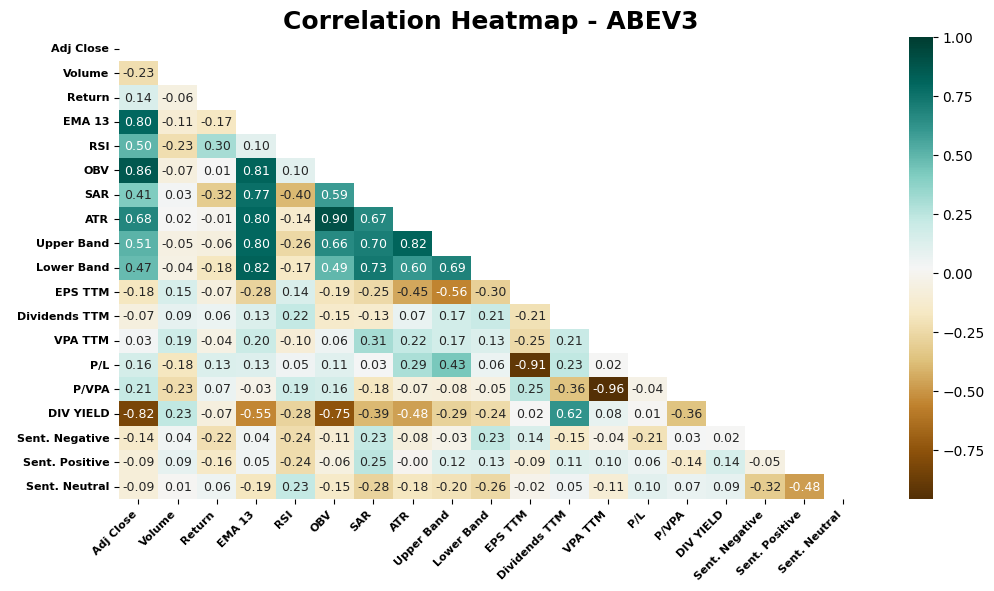

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = train_data[asset].iloc[:, :-1]

## Customizing the correlation heatmap:
plt.figure(figsize=(12, 6))
min = df.corr().min().min()
max = df.corr().max().max()
mask = np.triu(np.ones_like(df.corr(), dtype='bool')) # Triangular matrix

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=min, vmax=max, annot=True, fmt='.2f', cmap='BrBG',annot_kws={'size': 9})
heatmap.set_title(f'Correlation Heatmap - {asset}', loc = 'center', fontdict={'fontsize':18, 'fontweight': 'bold'})

# Customize x and y labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8, fontdict={'fontweight': 'semibold'})
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=8, fontdict={'fontweight': 'semibold'})

# Set axis labels
heatmap.set_xlabel('', fontsize=1, fontweight='bold')
heatmap.set_ylabel(' ', fontsize=1, fontweight='bold')


plt.show()


## Split Data: Features x Target

In [3]:
# Selecting only ITUB4
df_train = train_data[asset]
df_test  = test_data[asset]

# Train data:
X_train = df_train.iloc[:, :-1] # All except last
Y_train = df_train.iloc[:, -1]  # Only the last

# Test data:
X_test = df_test.iloc[:, :-1] # All except last
Y_test = df_test.iloc[:, -1]  # Only the last

## Label Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Encode the Y_train array:
Y_train_encoded = encoder.fit_transform(Y_train)
Y_test_encoded  = encoder.fit_transform(Y_test)


# Show output example:
print('Categorical data example:')
print(Y_test[:8])
print('\nEncoded data example:')
print(Y_test_encoded[:15])

Categorical data example:
Date
2023-06-12            Buy
2024-02-12        Neutral
2024-02-05           Sell
2023-11-20     Strong Buy
2023-09-25        Neutral
2024-08-26        Neutral
2024-08-12        Neutral
2023-10-09    Strong Sell
Name: Output, dtype: category
Categories (5, object): ['Strong Sell' < 'Sell' < 'Neutral' < 'Buy' < 'Strong Buy']

Encoded data example:
[0 1 2 3 1 1 1 4 4 1 0 1 1 1 0]


## Forest Tree Model

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2023-12-04 to 2024-10-28
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       82 non-null     float64
 1   Volume          82 non-null     int64  
 2   Return          82 non-null     float64
 3   EMA 13          82 non-null     float64
 4   RSI             82 non-null     float64
 5   OBV             82 non-null     float64
 6   SAR             82 non-null     float64
 7   ATR             82 non-null     float64
 8   Upper Band      82 non-null     float64
 9   Lower Band      82 non-null     float64
 10  EPS TTM         82 non-null     float64
 11  Dividends TTM   82 non-null     float64
 12  VPA TTM         82 non-null     float64
 13  P/L             82 non-null     float64
 14  P/VPA           82 non-null     float64
 15  DIV YIELD       82 non-null     float64
 16  Sent. Negative  82 non-null     float64
 17  Sent. Positive  8

In [6]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


asset_classifier = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=100, n_jobs=1, random_state=42)

# Measure training time
time.sleep(0.5)
start_time = time.time()

# Fit the model
itub_model = asset_classifier.fit(X_train, Y_train_encoded)
train_time = time.time() - start_time

# Make predictions
Y_pred = itub_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(Y_test_encoded, Y_pred)

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Overall Accuracy: {accuracy:.4%}")


Training Time: 6.3758 seconds
Overall Accuracy: 23.8095%


## PCA

In [7]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Scaling data
scaler = preprocessing.StandardScaler()
pca_data = scaler.fit_transform(X_train)

# Applying PCA
pca = PCA(n_components=None, whiten=True, random_state=42)
pca.fit(pca_data)

# Get proportions of variance and cumulative proportion of variance
prop_var = pca.explained_variance_ratio_
cum_prop = np.cumsum(pca.explained_variance_ratio_)
ind = ["Proportion of variance", "Cumulative prop of variance"]
cols = [f"PC{i+1}" for i in range(len(prop_var))]
pd.DataFrame(np.vstack((prop_var, cum_prop)), ind, columns=cols).T

,Proportion of variance,Cumulative prop of variance
PC1,0.311033,0.311033
PC2,0.160948,0.471981
PC3,0.126705,0.598686
PC4,0.085038,0.683724
PC5,0.065615,0.749339
PC6,0.061785,0.811124
PC7,0.053548,0.864672
PC8,0.046460,0.911132
PC9,0.033544,0.944676
PC10,0.023705,0.968381


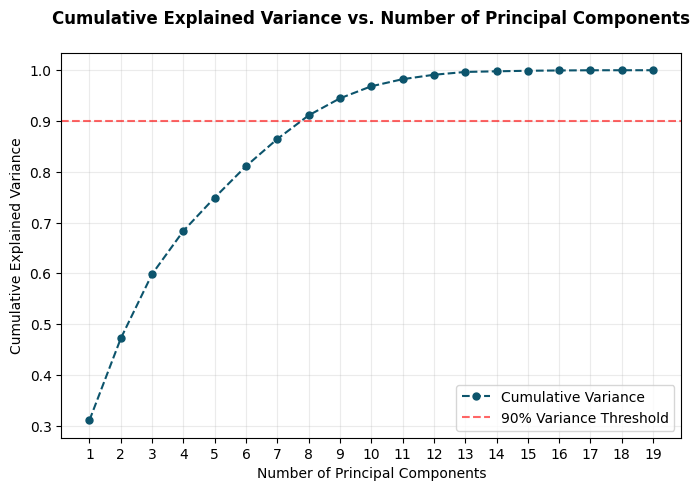

In [8]:
## Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_prop) + 1), cum_prop, marker='o', markersize=5, linestyle='--', color='#0c546c', label="Cumulative Variance")

## Highlight 90% threshold
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold", alpha = 0.6)

## Customizing
plt.xlabel("Number of Principal Components")
plt.xticks(ticks=range(1, len(cum_prop) + 1))
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs. Number of Principal Components\n",fontweight= 'semibold')
plt.legend(loc = 'lower right')
plt.grid(alpha=0.25)

# Show plot
plt.show()

## Forest Tree Model with PCA features

In [9]:
# Apply PCA again with selected components
n_comp = 8
pca_95 = PCA(n_components=n_comp, whiten=True, random_state=42)
X_train_pca = pca_95.fit_transform(X_train)
X_test_pca = pca_95.transform(X_test)  # Use transform for test data

# Convert to DataFrame
X_train_pca = pd.DataFrame(X_train_pca,index= X_train.index, columns=[f"PC{i+1}" for i in range(n_comp)])
X_test_pca  = pd.DataFrame(X_test_pca, index = X_test.index, columns=[f"PC{i+1}" for i in range(n_comp)])

# Display first few rows
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Date,,,,,,,,
2023-12-04,0.050191,-0.821622,2.434225,-0.936809,1.055319,-0.192125,-0.422064,-0.248304
2023-04-17,1.209245,-1.123410,-0.584684,-0.233744,0.349059,-1.157663,1.318887,-0.864402
2024-04-29,-1.139678,-0.757367,-0.669006,-0.355933,-0.217385,-0.380388,1.147779,-0.989963
2023-09-18,-0.220810,-0.579764,-0.485123,0.008000,-1.579494,1.110776,1.212578,1.463074
2024-04-01,-1.105435,0.944442,-0.439525,-0.701058,-0.494167,0.785950,0.660020,-1.168351


In [10]:
# Initialize classifier (same parameters as before)
pca_classifier = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=100, n_jobs=1, random_state=42)

# Measure training time
time.sleep(0.5)
start_time = time.time()

# Fit the model
pca_model = pca_classifier.fit(X_train_pca, Y_train_encoded)
train_time_pca = time.time() - start_time

# Make predictions
Y_pred = pca_model.predict(X_test_pca)

# Evaluate accuracy
accuracy_pca = accuracy_score(Y_test_encoded, Y_pred)

# Print metrics
print(f"Training Time: {train_time:.4f} seconds")
print(f"Overall Accuracy: {accuracy_pca:.4%}")

Training Time: 6.3758 seconds
Overall Accuracy: 33.3333%


# Comparison

In [11]:
print(' -------------- RAW -------------')
print(f"Training Time: {train_time:.4f} seconds")
print(f"Overall Accuracy: {accuracy:.4%}")

print('\n')

print(' -------------- PCA -------------')
print(f"Training Time: {train_time_pca:.4f} seconds")
print(f"Overall Accuracy: {accuracy_pca:.4%}")

 -------------- RAW -------------
Training Time: 6.3758 seconds
Overall Accuracy: 23.8095%


 -------------- PCA -------------
Training Time: 4.4185 seconds
Overall Accuracy: 33.3333%
